In [161]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import trange
try:
  from helpers import get_model_size, estimate_loss, normalize_tensor
except ModuleNotFoundError:
  import sys
  sys.path.append("../")
  from helpers import get_model_size, estimate_loss, normalize_tensor

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
# we actually just need it to download cifar dataset
# torchvision.datasets.CIFAR10(train=True, download=True, root='../data/', transform=transforms.ToTensor())
# torchvision.datasets.CIFAR10(train=False, download=True, root='../data/', transform=transforms.ToTensor())

In [153]:
class CiFaData(Dataset):
  def __init__(self, stage="train", transform=None, device="cpu"):
    # self.device = device
    self.base_folder = "cifar-10-batches-py"
    self.transform = transform
    if stage == "train":
      batch_collection = [f"data_batch_{i}" for i in range(1, 5)]
    elif stage == "val":
      batch_collection = ["data_batch_5"]
    elif stage == "test":
      batch_collection = ["test_batch"]
    else:
      raise ValueError("Invalid stage, choose from train, val, test.")
    self.x_data = []
    self.y_data = []
    for batch in batch_collection:
      with open(f"../data/cifar-10-batches-py/{batch}", "rb") as f:
        data = pickle.load(f, encoding="latin1") 
        self.x_data.extend(data["data"])
        self.y_data.extend(data["labels"])
    self.y_data = torch.tensor(self.y_data)
    self.x_data = normalize_tensor(torch.tensor(np.vstack(self.x_data).reshape(-1, 3, 32, 32))) # from list to vstack; results in (N, 3, 32, 32)
  def __len__(self):
    return self.y_data.shape[0]
  def __getitem__(self, idx):
    if self.transform:
      return self.transform(self.x_data[idx]), self.y_data[idx]
    return self.x_data[idx], self.y_data[idx]

In [156]:
# tf = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
tf = transforms.RandomRotation(degrees=(0, 180))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds = CiFaData(stage="train", device=device, transform=tf)
val_ds = CiFaData(stage="val", device=device)
test_ds = CiFaData(stage="test", device=device)

# pinning memory, takes cpu data and pins it to the gpu.
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=14, pin_memory=True) 
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=14, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=14, pin_memory=True)

ResNet 18

In [149]:
# from the paper: 
# We adopt batch normalization (BN) [16] right after each convolution and
# before activation, following [16].

In [150]:
class PrepBlock(nn.Module):
  # fixed channels for cifar
  def __init__(self):
    super().__init__()
    self.prep_block = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
  def forward(self, x):
    return self.prep_block(x)

class ComputeBlock(nn.Module):
  def __init__(self, inchannels, outchannels, stride):
    super().__init__()
    self.compute_block = nn.Sequential(
      nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=3, padding=1, stride=stride),
      nn.BatchNorm2d(outchannels),
      nn.ReLU(),
      nn.Conv2d(in_channels=outchannels, out_channels=outchannels, kernel_size=3, padding=1, stride=1),
      nn.BatchNorm2d(outchannels)     
    )
  def forward(self, x):
    return self.compute_block(x)

class ResidualBlock(nn.Module):
  # this is where the dimension matching happens if necessary 
  def __init__(self, inchannels, outchannels):
    super().__init__()
    self.res_block = nn.Sequential(
      nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=1, stride=2),
      nn.BatchNorm2d(outchannels)
    )
  def forward(self, x):
    return self.res_block(x)

In [151]:
class ResNet18(nn.Module):
  def __init__(self):
    super().__init__()
    self.prep_block = PrepBlock()
    self.compute_block1 = ComputeBlock(64, 64, stride=1)
    self.relu1 = nn.ReLU()
    self.res_block2 = ResidualBlock(64,128)
    self.compute_block2 = ComputeBlock(64,128, stride=2)
    self.relu2 = nn.ReLU()
    self.res_block3 = ResidualBlock(128,256)
    self.compute_block3 = ComputeBlock(128, 256, stride=2)
    self.relu3 = nn.ReLU()
    self.res_block4 = ResidualBlock(256, 512)
    self.compute_block4 = ComputeBlock(256, 512, stride=2)
    self.relu4 = nn.ReLU()
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, 10)
  def forward(self, x):
    # -------- prep block --------
    x_skip = self.prep_block(x) # (B,64,8,8)
    # ---------- Block1 ---------- 
    x = self.compute_block1(x_skip) # (B,64,8,8)
    x_skip = self.relu1(x+x_skip)
    # ---------- Block2 ---------- 
    x_skip = self.res_block2(x_skip) # (B,128,4,4)
    x = self.compute_block2(x)
    x = self.relu2(x+x_skip)
    # ---------- Block3 ---------- 
    x_skip = self.res_block3(x) # (B,256,2,2)
    x = self.compute_block3(x)
    x = self.relu3(x+x_skip)
    # ---------- Block4 ---------- 
    x_skip = self.res_block4(x) # (B,512,1,1)
    x = self.compute_block4(x)
    x = self.relu4(x+x_skip)
    # ---------- Linear ----------
    x = self.avg_pool(x)
    x = torch.flatten(x, start_dim=1) # (B,512)
    return self.fc(x) # (B,10)

In [163]:
epochs = 200
lr = 0.1
model = ResNet18()
model.to(device)

# optimizer = optim.AdamW(params=[p for p in model.parameters() if p.requires_grad==True], lr=lr)
optimizer = optim.SGD(params=model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)
criterion = nn.CrossEntropyLoss()

model_size = get_model_size(model)

# training loop
losses = []
raw_losses = []
val_losses = []

for i in (t:=trange(epochs)):
  epoch_loss = []
  for step, (x, y) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
    predictions = model(x)
    loss = criterion(predictions, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    raw_losses.append(loss.item())
    epoch_loss.append(loss.item())

  # only one per iteration
  losses.append(np.mean(epoch_loss))
  val_losses.append(estimate_loss(model, val_loader, criterion, device))
  scheduler.step()
  t.set_description(f"epoch {i+1} | training loss: {losses[-1]:.4f} | validation loss: {val_losses[-1]:.4f} | current lr: {optimizer.param_groups[0]['lr']:.6f}")
  
test_loss = estimate_loss(model, test_loader, criterion, device) 
print(f'test loss : {test_loss}')

model size: 18.767 MB


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 200 | training loss: 0.1962 | validation loss: 1.2324 | current lr: 0.000000: 100%|██████████| 200/200 [07:41<00:00,  2.31s/it]


test loss : 1.2724331736564636


In [85]:
# currently: 4.01s/it
# after custom normalize: 2.04
# modular definition: 1.89, yay. but model size increased from 41.97 to 42.63 MB. speed stays the same if I pull relu inside init.
# adding batchnorm layers makes it way slower again: 2.33s/it

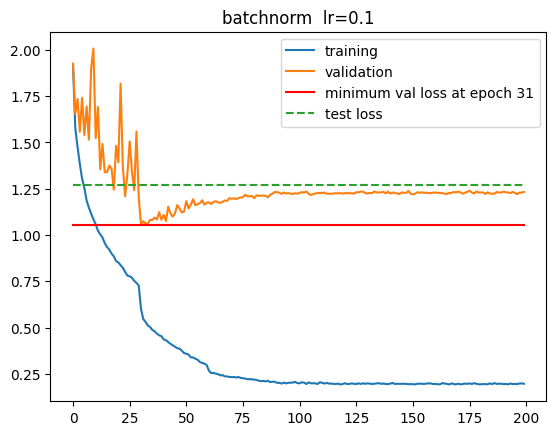

In [164]:
plt.figure()
plt.title(f'batchnorm  lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

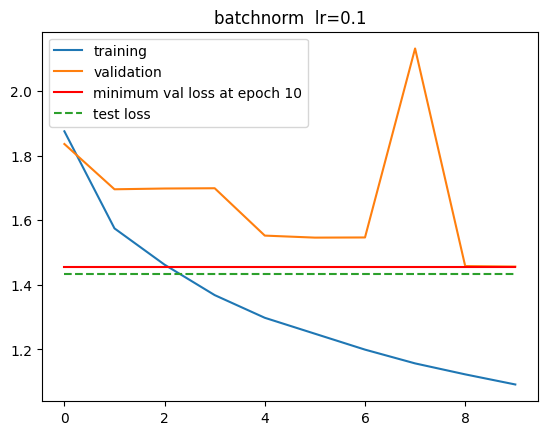

In [131]:
plt.figure()
plt.title(f'batchnorm  lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

# todos:
## add a good scheduler
## check if batchnorm is properly applied - probably yes
## hyperparameter tuning
## extract feature detection layers
## increase size: make a resnet 50
### add bottlenecks

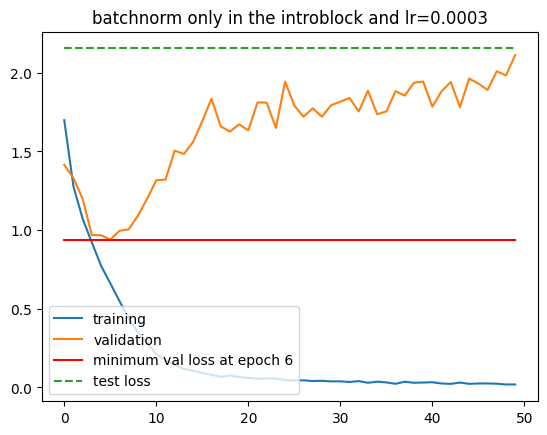

In [54]:
plt.figure()
plt.title(f'batchnorm only in the introblock and lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

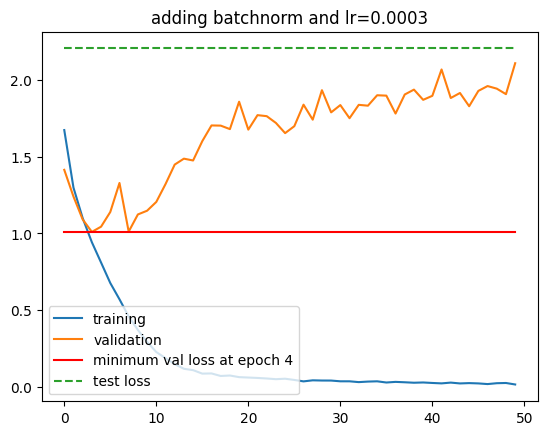

In [47]:
# better, but still seems to diverge beginning in about epoch 30 or so
plt.figure()
plt.title(f'adding batchnorm and lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

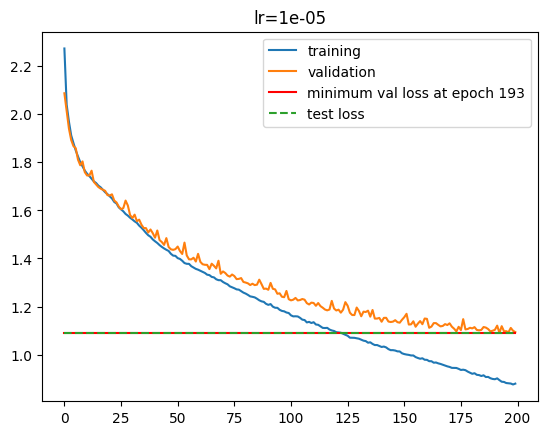

In [66]:
# better, but still seems to diverge beginning in about epoch 30 or so
plt.figure()
plt.title(f'lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

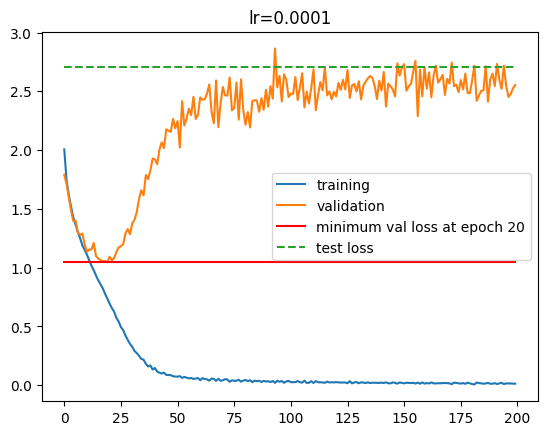

In [63]:
# we can either adapt the learning rate at about 25 or make it way smaller
plt.figure()
plt.title(f'lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

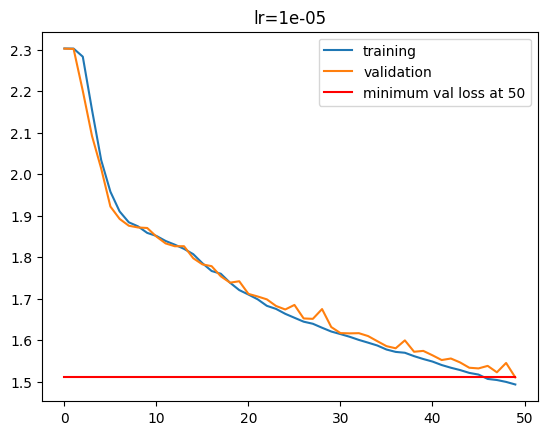

In [27]:
plt.figure()
plt.title(f'lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.legend()
plt.show()

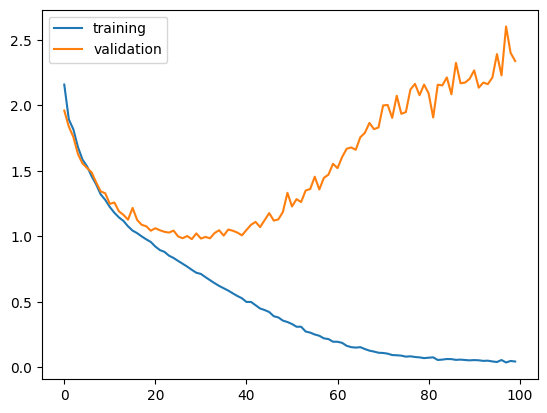

In [13]:
plt.figure()
plt.title('lr=0.0001')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), np.min(val_losses))
plt.legend()
plt.show()

# visualize feature maps

we can loop over the elements with model.children() or just address individual layers like:
model.block0[n]; you can go down until you hit a 'Sequential' block and then go on slicing


seems like a good guide: 
https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

In [74]:
weights.shape

torch.Size([512, 512, 3, 3])

In [113]:
res18.block4.block[1].block[0]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [114]:
weights = res18.block4.block[1].block[0].weight.detach().clone()
print(weights.shape)
weights = normalize_tensor(weights)
filter_img = torchvision.utils.make_grid(weights, nrow=int(np.sqrt(weights.shape[0])))
plt.imshow(filter_img.permute(1,2,0))

torch.Size([512, 512, 3, 3])


TypeError: Invalid shape (122, 112, 512) for image data

In [75]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

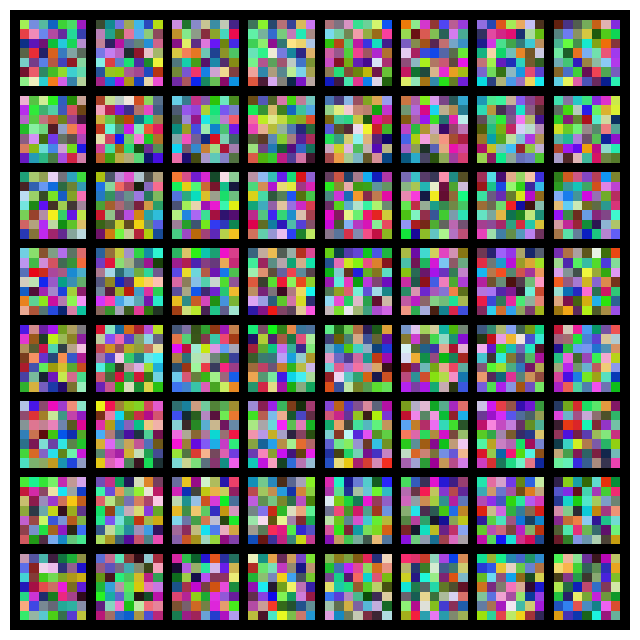

In [84]:
layer = res18.block0[0].weight.detach().clone()
visTensor(layer)
plt.axis('off')
plt.ioff()
plt.show()

In [103]:
res18.block1.block[0]


SubBlock(
  (block): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [92]:
# first_block = res18.block0[0].weight.detach().clone()
first_block = res18.block1.block[0].weight.detach.clone()
print(first_block.shape)
first_block =normalize_tensor(first_block)
filter_img = torchvision.utils.make_grid(first_block, nrow=int(np.sqrt(first_block.shape[0])))
plt.axis('off')
plt.ioff()
plt.imshow(filter_img.permute(1,2,0))
plt.show()

AttributeError: 'SubBlock' object has no attribute 'weight'

In [21]:
weights = []
conv_layers = []

model_children = list(res18.children())

cnt = 0

for i in range(len(model_children)):
  # this only counts the shape shifter-convs! - need to go into the sub blocks
  if type(model_children[i]) == nn.Conv2d:
    cnt +=1

print(cnt)

3
